# 药物-靶点相互作用预测

在此教程中，我们将展示如何使用 GraphDTA 模型进行药物与靶点蛋白相互作用的预测。具体来说，我们将介绍如何训练、评估 GraphDTA 模型，以及如何使用模型针对给定蛋白和药物分子进行推断。GraphDTA 模型的实现请参阅 `../apps/drug_target_interaction/graph_dta/` 目录下的代码。

# GraphDTA

GraphDTA 模型能够将药物分子转换成其对应的图表示，从而利用图神经网络来预测药物与靶点的亲和性。具体来说，我们使用了 RDKit 工具包将化合物的 SMILES 转换为图，该图结构经过多种可选的图神经网络模型，提取得到最终的图表示。对于蛋白质，其氨基酸序列会先从 embedding 矩阵中查找每个氨基酸对应的向量，组成的向量序列经过序列卷积形蛋白质的表示。最后，将药物分子和蛋白质的表示拼接起来，输入前馈神经网络，对亲和性的指标如 Kd, Ki, KIBA 等进行回归学习。

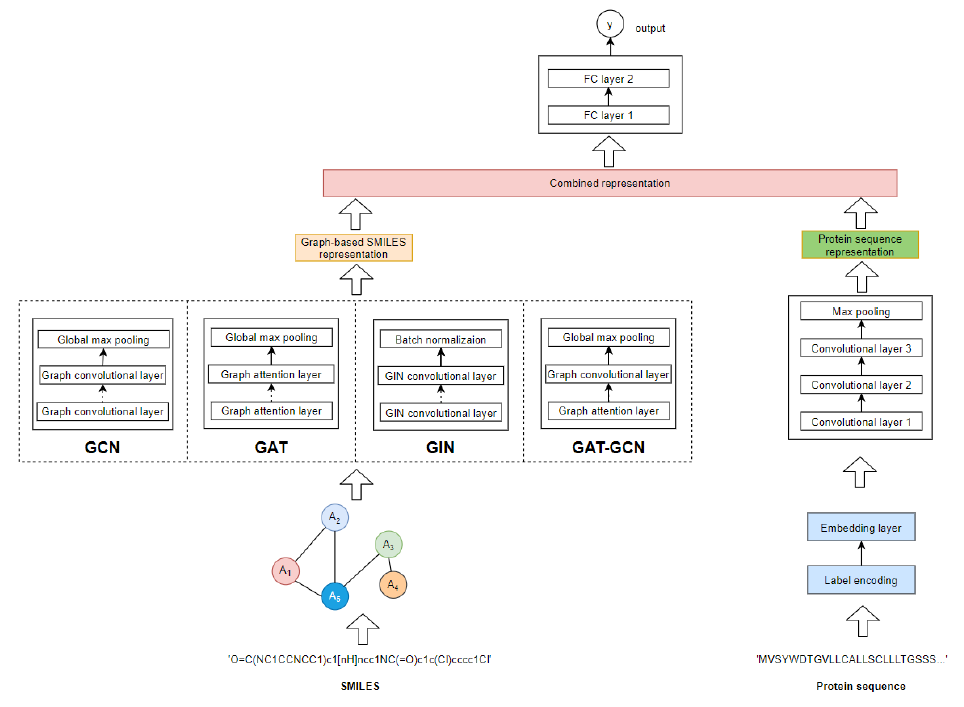

GraphDTA 的代码实现请查阅 `../apps/drug_target_interaction/graph_dta/` 目录中的内容，为执行后面的代码片段，需要将运行路径移到该目录下（如下所示）。

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
os.chdir('../apps/drug_target_interaction/graph_dta/')

## 数据集的准备

下载原数据到`data`目录下，使用`scripts/preprocess_data.py`脚本预处理后，`data`目录结构如下：

In [2]:
!tree data

data
├── davis
│   ├── folds
│   │   ├── test_fold_setting1.txt
│   │   └── train_fold_setting1.txt
│   ├── ligands_can.txt
│   ├── processed
│   │   ├── test
│   │   │   └── davis_test.npz
│   │   └── train
│   │       └── davis_train.npz
│   ├── proteins.txt
│   └── Y
└── kiba
    ├── folds
    │   ├── test_fold_setting1.txt
    │   └── train_fold_setting1.txt
    ├── ligands_can.txt
    ├── processed
    │   ├── test
    │   │   └── kiba_test.npz
    │   └── train
    │       └── kiba_train.npz
    ├── proteins.txt
    └── Y

10 directories, 14 files


其中`data/davis/processed/train`为我们后续要使用的训练数据目录，`data/davis/processed/test`为测试数据目录。

对于靶点蛋白的氨基酸序列，有两种不同的方式做为输入：
* 通过裁剪或拼接占位符的方式将蛋白序列转换为固定长度，代码实现中等价于设定超参数 `max_protein_len` 的值大于0。
* 使用全长度的蛋白质序列，代码实现中等价于设定超参数 `max_protein_len` 的值小于0。

In [3]:
train_data = 'data/davis/processed/train'
test_data = 'data/davis/processed/test'
max_protein_len = 1000  # 设置为-1时使用全长蛋白质序列

In [4]:
from src.data_gen import DTADataset

train_dataset = DTADataset(train_data, max_protein_len=max_protein_len)
test_dataset = DTADataset(test_data, max_protein_len=max_protein_len)
print('训练集数量:', len(train_dataset))
print('测试集数量:', len(test_dataset))

训练集数量: 25046
测试集数量: 5010


## 模型创建

在本教程中，我们使用 GIN 网络作为例子，更多的网络结构配置参见 `model_configs/` 目录下的 `*_config.json` 文件。

`model_config` 展示了整个网络结构的超参数配置。其中，`model_config['compound']` 是药物分子的图神经网络结构的超参数配置，`model_config['protein']` 是基于序列卷积网络的蛋白质表示模块的超参数配置。

In [5]:
lr = 0.0005                                         # 学习率
model_config = {
    "compound": {
        "atom_names": ["atomic_num", "chiral_tag"], # 化合物药物表示为图时节点的特征
        "bond_names": ["bond_dir", "bond_type"],    # 化合物药物表示为图时边的特征

        "gnn_type": "gin",                          # 图神经网络类型
        "dropout_rate": 0.2,                        # 图神经网络dropout操作的丢弃概率

        "embed_dim": 32,                            # 原子类型的embedding矩阵的纬度
        "layer_num": 5,                             # 图卷积神经网络的层数
        "hidden_size": 32,                          # 图卷积神经网络隐含层的大小
        "output_dim": 128                           # 化合物药物表征向量的纬度
    },

    "protein": {
        "max_protein_len": max_protein_len,         # 设置为-1时使用全长蛋白质序列作为输入
        "embed_dim": 128,                           # 氨基酸类别的embedding矩阵的纬度
        "num_filters": 32,                          # 序列卷积的滤波器的数量
        "output_dim": 128                           # 靶标蛋白表征向量的纬度
    },

    "dropout_rate": 0.2                             # 亲和性预测网络dropout操作的丢弃概率
}

/mnt/xueyang/anaconda3/envs/paddle2.0/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


创建Paddle的网络模型、损失函数和优化器：

In [6]:
import paddle
import numpy as np
from src.model import DTAModel, DTAModelCriterion

model = DTAModel(model_config)
criterion = DTAModelCriterion()
optimizer = paddle.optimizer.Adam(
    learning_rate=lr,
    parameters=model.parameters())

2021-05-10 17:16:35,296 - INFO - Enabling RDKit 2020.09.5 jupyter extensions


[GLOBAL] POLAR_ANGLE_NUM:10


## 训练与评估

创建训练和评估所需的dataloader

In [7]:
from src.data_gen import DTACollateFunc

max_epoch = 2                     # 这里使用小的训练轮数方便演示
batch_size = 512                  # 训练时实验的批次数据大小
num_workers = 4                   # PGL dataloader的并行worker数目

collate_fn = DTACollateFunc(
    model_config['compound']['atom_names'],
    model_config['compound']['bond_names'],
    is_inference=False,
    label_name='Log10_Kd')

train_dataloader = train_dataset.get_data_loader(
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate_fn)

test_dataloader = test_dataset.get_data_loader(
        batch_size=batch_size,
        num_workers=1,
        shuffle=False,
        collate_fn=collate_fn)

创建训练函数 `train()`：

In [8]:
def train(model, criterion, optimizer, dataloader):
    model.train()
    list_loss = []
    for graphs, proteins_token, proteins_mask, labels in dataloader:
        graphs = graphs.tensor()
        proteins_token = paddle.to_tensor(proteins_token)
        proteins_mask = paddle.to_tensor(proteins_mask)
        labels = paddle.to_tensor(labels)
        
        preds = model(graphs, proteins_token, proteins_mask)
        loss = criterion(preds, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        list_loss.append(loss.numpy())
    return np.mean(list_loss)

在评估函数 `evaluate()` 中，我们使用均方误差（MSE）和一致性指数（CI）评估模型效果。然而，考虑到计算基于排序的 CI 非常耗时，我们在传入参数中引入了之前的最小均方误差`prior_best_mse`，只有当前均方误差为新低时（意味着模型性能有所提升），才会计算新的 CI。

In [9]:
from src.utils import concordance_index

def evaluate(model, dataloader, prior_best_mse):
    model.eval()
    total_pred, total_label = [], []
    for graphs, proteins_token, proteins_mask, labels in dataloader:
        graphs = graphs.tensor()
        proteins_token = paddle.to_tensor(proteins_token)
        proteins_mask = paddle.to_tensor(proteins_mask)
        
        preds = model(graphs, proteins_token, proteins_mask)
        total_pred.append(preds.numpy())
        total_label.append(labels)

    total_pred = np.concatenate(total_pred, 0).flatten()
    total_label = np.concatenate(total_label, 0).flatten()
    mse = ((total_label - total_pred) ** 2).mean(axis=0)

    ci = None
    if mse < prior_best_mse:
        # Computing CI is time consuming
        ci = concordance_index(total_label, total_pred)
        
    return mse, ci

在训练和评估的流程中，我们每训练一轮数据，就评估一次模型。如果模型在测试集上取得了更小的均方误差，则更新保存的最优模型参数以及评估指标。

In [10]:
paddle.set_device('gpu')
best_mse, best_ci, best_ep = np.inf, 0, 0
best_model = 'best_model.pdparams'

metric = None
for epoch_id in range(1, max_epoch + 1):
    print('========== Epoch {} =========='.format(epoch_id))
    train_loss = train(model, criterion, optimizer, train_dataloader)
    print('Epoch: {}, Train loss: {}'.format(epoch_id, train_loss))
    mse, ci = evaluate(model, test_dataloader, best_mse)
    
    if mse < best_mse:
        best_mse, best_ci, best_ep = mse, ci, epoch_id  
        paddle.save(model.state_dict(), best_model)
        metric = 'Epoch: {}, Best MSE: {}, Best CI: {}'.format(epoch_id, best_mse, best_ci)
        print(metric)
    else:
        print('No improvement in epoch {}'.format(epoch_id))
        print('Current best: ({})'.format(metric))

========== Epoch 1 ==========


/mnt/xueyang/anaconda3/envs/paddle2.0/lib/python3.8/site-packages/paddle/nn/layer/norm.py:647: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


Epoch: 1, Train loss: 2.350405693054199
Epoch: 1, Best MSE: 1.3980894088745117, Best CI: 0.7544100689906765
========== Epoch 2 ==========
Epoch: 2, Train loss: 0.7952787280082703
Epoch: 2, Best MSE: 0.9572187662124634, Best CI: 0.7770249729187818


## 利用模型进行推断

在推断一节，我们将通过一组药物-靶点蛋白序列实例，展示 GraphDTA 模型输入数据的细节，以及预测 Kd 的过程。

In [11]:
import pgl
from rdkit.Chem import AllChem
from pahelix.utils.protein_tools import ProteinTokenizer
from pahelix.utils.compound_tools import mol_to_graph_data

protein_example = 'MENKKKDKDKSDDRMARPSGRSGHNTRGTGSSSSGVLMVGPNFRVGKKIGCGNFGELRLGKNLYTNEYVAIKLEPMKSRAPQLHLEYRFYKQLGSGDGIPQVYYFGPCGKYNAMVLELLGPSLEDLFDLCDRTFSLKTVLMIAIQLISRMEYVHSKNLIYRDVKPENFLIGRPGNKTQQVIHIIDFGLAKEYIDPETKKHIPYREHKSLTGTARYMSINTHLGKEQSRRDDLEALGHMFMYFLRGSLPWQGLKADTLKERYQKIGDTKRATPIEVLCENFPEMATYLRYVRRLDFFEKPDYDYLRKLFTDLFDRKGYMFDYEYDWIGKQLPTPVGAVQQDPALSSNREAHQHRDKMQQSKNQSADHRAAWDSQQANPHHLRAHLAADRHGGSVQVVSSTNGELNTDDPTAGRSNAPITAPTEVEVMDETKCCCFFKRRKRKTIQRHK'
drug_example = 'CCN1C2=C(C=CC(=C2)OC)SC1=CC(=O)C'

# 处理药物分子
mol = AllChem.MolFromSmiles(drug_example)
mol_graph = mol_to_graph_data(mol)

# 处理蛋白质序列
tokenizer = ProteinTokenizer()
protein_token_ids = tokenizer.gen_token_ids(protein_example)

# 融合药物分子和蛋白数据
data = {k: v for k, v in mol_graph.items()}
data['protein_token_ids'] = np.array(protein_token_ids)

# 当设定最大蛋白序列长度时，进行截取或加padding，使得序列满足条件
if max_protein_len > 0:
    protein_token_ids = np.zeros(max_protein_len, dtype=np.int64) + ProteinTokenizer.padding_token_id
    n = min(max_protein_len, data['protein_token_ids'].size)
    protein_token_ids[:n] = data['protein_token_ids'][:n]
    data['protein_token_ids'] = protein_token_ids
    
infer_collate_fn = DTACollateFunc(
    model_config['compound']['atom_names'],
    model_config['compound']['bond_names'],
    is_inference=True,
    label_name='Log10_Kd')

# 处理成DTAModel接收的数据
join_graph, proteins_token, proteins_mask = infer_collate_fn([data])

[GLOBAL] POLAR_ANGLE_NUM:10


In [12]:
join_graph = join_graph.tensor()
proteins_token = paddle.to_tensor(proteins_token)
proteins_mask = paddle.to_tensor(proteins_mask)

model.eval()
affinity_pred = model(join_graph, proteins_token, proteins_mask)
affinity_pred = affinity_pred.numpy()[0][0]
print('亲和力预测:', affinity_pred)

亲和力预测: 4.1884127


转换为Kd值：

In [13]:
Kd = 10 ** (-affinity_pred)
print('Kd: %f Mol' % Kd)

Kd: 0.000065 Mol
